## Import packages

In [145]:
import pandas as pd
import numpy as np
from numpy import arange
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse 
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score
from geopy import distance
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
from xgboost import XGBRegressor, plot_importance
import lightgbm
from lightgbm import LGBMRegressor, plot_importance
from sklearn.linear_model import RidgeCV, Ridge
warnings.filterwarnings("ignore")
from scipy.special import boxcox1p
from scipy.stats import norm, skew

In [255]:
warnings.simplefilter('ignore')

## Data Preprocessing

In [241]:
df = pd.read_csv('kc_house_data.csv')

# Clean date column
df['date']=df['date'].str.replace("T000000"," ")
df['date'] = pd.to_datetime(df['date'])

# Log transform price column
df['price'] = np.log(df['price'])


## Exploratory Data Analysis

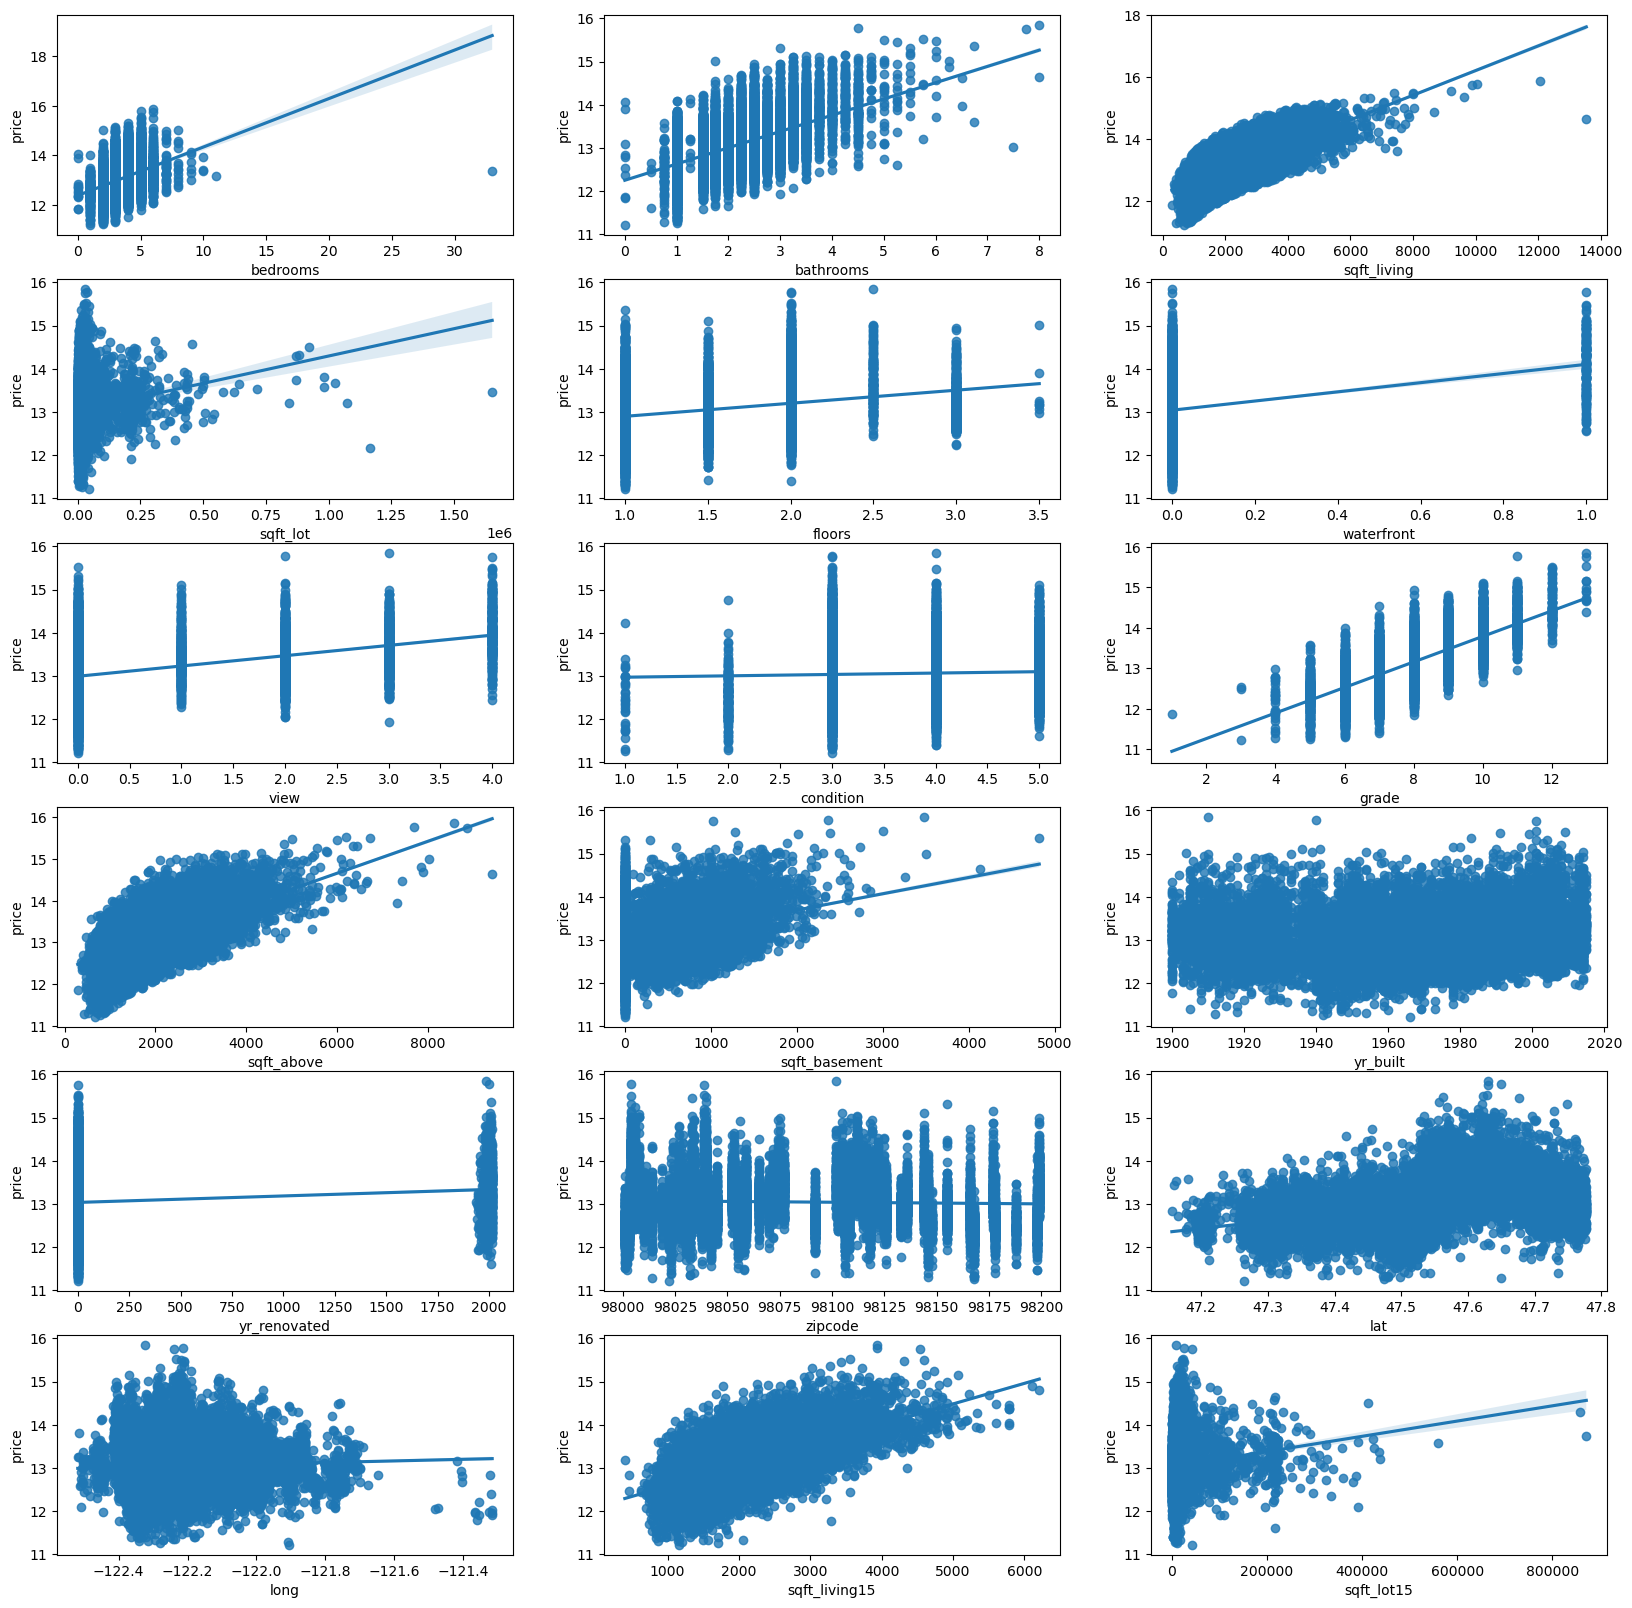

In [242]:
# Preview relationship between features and price
rls = df.drop(columns=['price','date','id'], axis=1)
fig, axes = plt.subplots(6,3,figsize = (20,20))
for ax, col in zip(axes.flatten(), rls.columns):
    sns.regplot(x=rls[col], y= df.price,ax=ax)
plt.show()

In [243]:
# Dropping outlier for sqft_living
df = df.drop(df[(df['sqft_living']>13000)].index)

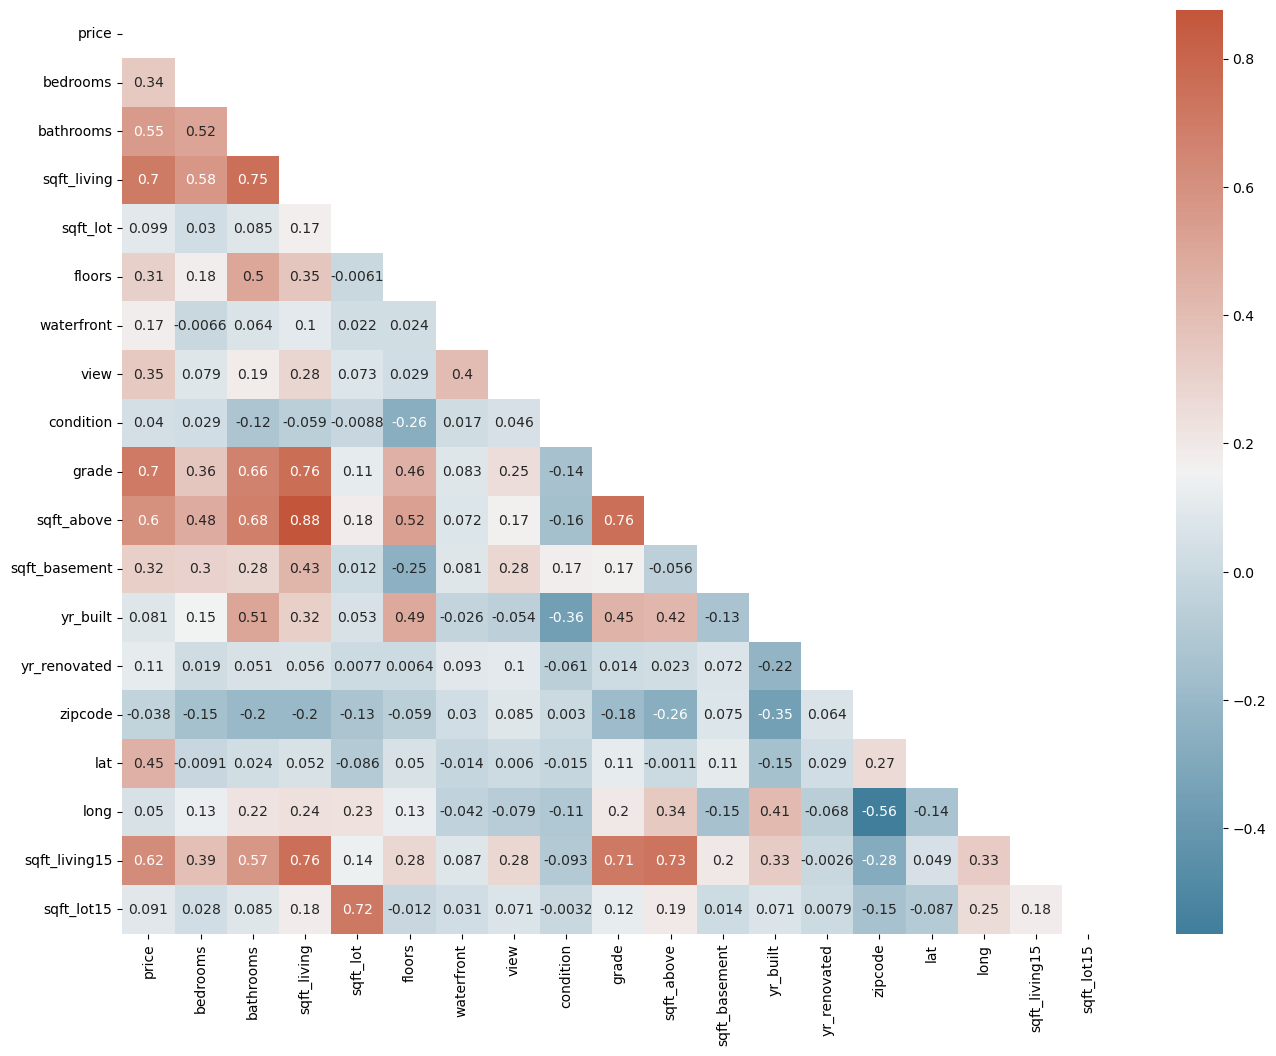

In [244]:
# Correlation Matrix 
df_cm = df.drop(columns=['id', 'date'],axis=1)
corr = df_cm.corr()
f, ax = plt.subplots(figsize=(16, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)
plt.show()

In [245]:
# Check the skew of all features
skew_values = df.skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skew_values})
# Box Cox Transformation for highly skewed features
skewed_features = ["sqft_lot", "sqft_lot15"]
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)
    

## Feature Engineering

In [246]:
# Finding year and month from date 
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Finding distance (km) from downtown Medina using lat and long
lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
lat_long = list(map(eval,lat_long))
Medina = (47.6248,-122.2361)
km = []
for i in lat_long:
    km.append(round(distance.distance(i,Medina).km,2))
df['distance'] = km
df = df.drop(columns=['lat', 'long'], axis =1)

# Finding house age from yr_built
df['age_asof_2016'] = 2016 - df.yr_built
df = df.drop(columns=['yr_built'], axis =1)

# Changing yr_renovated into if renovated within 10 years (binary variable)
df['renovated'] = 2016-df.yr_renovated
renovated = df.renovated.values
age = df.age_asof_2016.values
values = np.where(renovated <= 10,1,0)
df['renovated'] = np.where(age <= 10,1,values)
df=df.drop(columns=['yr_renovated'],axis=1)

df= df.drop(columns=['id', 'date'],axis=1)

## Training, Validation, Test Sets 

In [248]:
# Splitting Data into Training and Test Sets
X = df.loc[:, df.columns != 'price']
y = np.ravel(df.loc[:, df.columns == 'price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Setup cross validation folds
kf = KFold(n_splits=10,  random_state = 42, shuffle=True)



## Linear Regression
- benchmark model

In [249]:
#fitting the model
linreg = LinearRegression()
model = linreg.fit(X_train,y_train)

#view model summary in statsmodel
X_train_lr = sm.add_constant(X_train)
smmodel = sm.OLS(y_train,X_train_lr).fit()
print(smmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     3595.
Date:                Thu, 05 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:29:41   Log-Likelihood:                 65.280
No. Observations:               17289   AIC:                            -92.56
Df Residuals:                   17270   BIC:                             54.84
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -60.5863     13.361     -4.535

In [252]:
# Use OLS model on test and train set 
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluate OLS model 
train_score = cross_val_score(model, X_train, y_train, cv = kf, scoring='r2')
print('Train Score:', round(train_score.mean(), 5))
test_score = model.score(X_test, y_test)
print('Test Score:', round(test_score, 5))

rmse_train = cross_val_score(model, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
print('Train RMSE:' , round(-rmse_train.mean(), 5))
rmse_test = np.sqrt(mse(y_test,y_pred))
print('Test RMSE:' , round(rmse_test, 5) )


Train Score: 0.78844
Test Score: 0.78856
Train RMSE: 0.24123
Test RMSE: 0.24461


## Ridge Regression

In [254]:
# Load Ridge Regression model with Hyperparameter Tuning
ridge = RidgeCV(alphas = arange(0, 1, 0.01), cv = kf, scoring = 'neg_root_mean_squared_error')

ridge.fit(X_train,y_train)

print('Alpha:' , ridge.alpha_ )

# Use Ridge Regression model on test and train set 
y_pred_ridge = ridge.predict(X_test)
y_pred_ridge_train=ridge.predict(X_train)

# Evaluate Ridge Regression model 
ridge_trainscore = cross_val_score(ridge , X_train, y_train, cv = kf, scoring='r2')
print('Train Score:', round(ridge_trainscore.mean(), 5))
ridge_testscore = ridge.score(X_test, y_test)
print('Test Score:', round(ridge_testscore, 5))

ridge_rmse_train = cross_val_score(ridge, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
print('Train RMSE:' , round(-ridge_rmse_train.mean(), 5))
ridge_rmse = np.sqrt(mse(y_test,y_pred_ridge))
print('Test RMSE:' , round(ridge_rmse, 5) )



Alpha: 0.05
Train Score: 0.78842
Test Score: 0.78856
Train RMSE: 0.24124
Test RMSE: 0.24461


## Random Forest

In [177]:
RandomForest=RandomForestRegressor(random_state=0)

# Hyperparameter Tuning: Setup the parameters and distributions to sample from
param_dist = {'max_depth': [int(x) for x in np.linspace(start = 5, stop = 13, num = 6)],
              'n_estimators' : [int(x) for x in np.linspace(start = 500, stop = 1000, num = 11)],
              'min_samples_leaf': [2,4,6],
              'min_samples_split' : [2,4,6],
              'max_features' : ['sqrt', 'log2']}
                                

# Instantiate the RandomisedSearchCV object
rf_randomised = RandomizedSearchCV(RandomForest, param_dist, 
                                   n_iter = 100, 
                                   scoring='neg_root_mean_squared_error',
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=0)
rf_randomised.fit(X_train, y_train) 

best_hyperparams = rf_randomised.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'n_estimators': 750, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 13}


In [ ]:
# Update Random Forest parameters according to RandomisedSearchCV results
RandomForest=rf_randomised.best_estimator_

# Use Random Forest model on train and test set  
y_pred_rf=RandomForest.predict(X_test)
y_pred_rf_train=RandomForest.predict(X_train)

# Evaluate Random Forest model 
rf_trainscore = cross_val_score(RandomForest , X_train, y_train, cv = kf)
rf_testscore = RandomForest.score(X_test, y_test)
rf_rmse_train = cross_val_score(RandomForest, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
rf_rmse = np.sqrt(mse(y_test,y_pred_rf))

In [183]:
print('Train Accuracy Score:', round(rf_trainscore.mean(), 5))
print('Test Accuracy Score:', round(rf_testscore, 5))
print('Train RMSE:' , round(-rf_rmse_train.mean(), 5))
print('Test RMSE:' , round(rf_rmse, 5) )

Train Accuracy Score: 0.85041
Test Accuracy Score: 0.84998
Train RMSE: 0.20284
Test RMSE: 0.20604


In [184]:
#Feature importance 
feature_imp_rf = pd.Series(RandomForest.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
feature_imp_rf

distance         0.201488
grade            0.186006
sqft_living      0.163427
sqft_living15    0.108016
sqft_above       0.083835
bathrooms        0.049268
zipcode          0.042602
age_asof_2016    0.031919
sqft_lot15       0.027775
sqft_lot         0.022185
view             0.021767
sqft_basement    0.019568
bedrooms         0.012964
floors           0.010529
condition        0.006200
month            0.005830
waterfront       0.004082
year             0.001514
renovated        0.001025
dtype: float64

## XGBoost 


In [185]:
xgb_est = XGBRegressor(random_state=0)

param_dist = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'min_child_weight': [int(x) for x in np.linspace(start = 4, stop = 12, num = 5)],
    'gamma': [0.15, 0.2, 0.25 , 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5,0.6, 0.7, 0.8, 0.9],
    'max_depth': [int(x) for x in np.linspace(start = 8, stop = 12, num = 5)],
    'reg_alpha':[0.03,0.04,0.05],
    'n_estimators': [int(x) for x in np.linspace(start = 500, stop = 1000, num = 5)]
}

xgb_random = RandomizedSearchCV(xgb_est, param_dist, 
                                n_iter = 100,
                                scoring = 'neg_root_mean_squared_error',
                                cv = 5,
                                n_jobs = -1,
                                verbose = 0)
# Fit the random search model
xgb_random.fit(X_train, y_train)

best_hyperparams = xgb_random.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'subsample': 0.9, 'reg_alpha': 0.05, 'n_estimators': 1000, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.5}


In [186]:
# Update XGB parameters according to RandomisedSearchCV results
xgb = xgb_random.best_estimator_

xgb.fit(X_train,y_train)

# Use XGB model on train and test set  
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_train=xgb.predict(X_train)

# Evaluate XGB model 
xgb_trainscore = cross_val_score(xgb , X_train, y_train, cv = kf)
xgb_testscore = xgb.score(X_test, y_test)
xgb_rmse_train = cross_val_score(xgb, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
xgb_rmse = np.sqrt(mse(y_test,y_pred_xgb))

In [187]:
print('Train Accuracy Score:', round(xgb_trainscore.mean(), 5))
print('Test Accuracy Score:', round(xgb_testscore, 5))
print('Train RMSE:' , round(-xgb_rmse_train.mean(), 5))
print('Test RMSE:' , round(xgb_rmse, 5) )

Train Accuracy Score: 0.90365
Test Accuracy Score: 0.90151
Train RMSE: 0.16275
Test RMSE: 0.16695


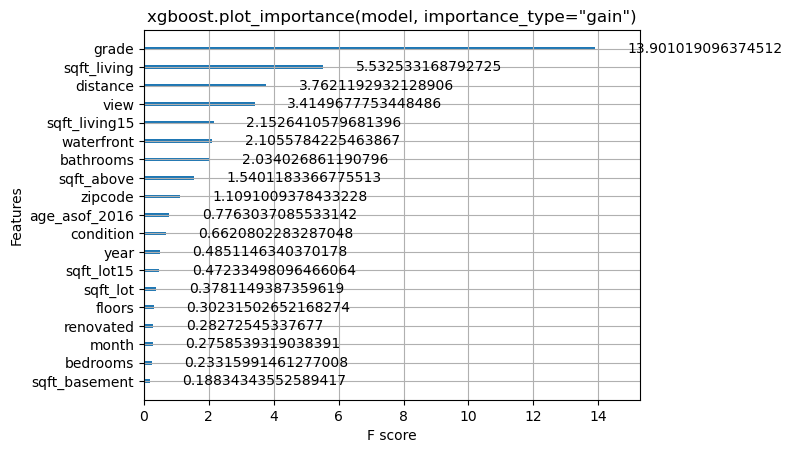

In [188]:
#feature importance
xgboost.plot_importance(xgb, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

## LightGBM 

In [ ]:
lgbm_est = LGBMRegressor(random_state=0)

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 500, stop = 1000, num = 11)],
    'learning_rate' : [x for x in np.linspace(start = 0.01, stop = 0.05, num = 9)],
    'num_leaves': [int(x) for x in np.linspace(start = 300, stop = 700, num = 9)],
    'max_depth': [int(x) for x in np.linspace(start = 10, stop = 15, num = 5)],
    'min_gain_to_split': [1,2,3],
    'feature_fraction':[x for x in np.linspace(start = 0.2, stop = 0.8, num = 7)],
    'bagging_fraction':[x for x in np.linspace(start = 0.2, stop = 0.8, num = 7)]
}

lgbm_random = RandomizedSearchCV(lgbm_est, param_dist, 
                                 scoring = 'neg_root_mean_squared_error',
                                 n_iter = 100,
                                 cv = 5,
                                 n_jobs = -1,
                                 verbose = -1)
# Fit the model
lgbm_random.fit(X_train, y_train)

In [256]:
best_hyperparams = lgbm_random.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'num_leaves': 400, 'n_estimators': 900, 'min_gain_to_split': 1, 'max_depth': 15, 'learning_rate': 0.015, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000000000000002}


In [217]:
# Update LightGBM parameters according to RandomisedSearchCV results
lgbm = lgbm_random.best_estimator_

lgbm.fit(X_train,y_train)

# Use LightGBM model on train and test set  
y_pred_lgbm = lgbm.predict(X_test)
y_pred_lgbm_train=lgbm.predict(X_train)

# Evaluate LightGBM model 
lgbm_trainscore = cross_val_score(lgbm , X_train, y_train, cv = kf)
lgbm_testscore = lgbm.score (X_test, y_test)
lgbm_rmse_train = cross_val_score(lgbm, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
lgbm_rmse = np.sqrt(mse(y_test,y_pred_lgbm))

[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000002
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000002
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current va

In [218]:
print('Train Accuracy Score:', round(lgbm_trainscore.mean(), 5))
print('Test Accuracy Score:', round(lgbm_testscore, 5))
print('Train RMSE:' , round(-lgbm_rmse_train.mean(), 5))
print('Test RMSE:' , round(lgbm_rmse, 5) )

Train Accuracy Score: 0.87902
Test Accuracy Score: 0.87806
Train RMSE: 0.18256
Test RMSE: 0.18576


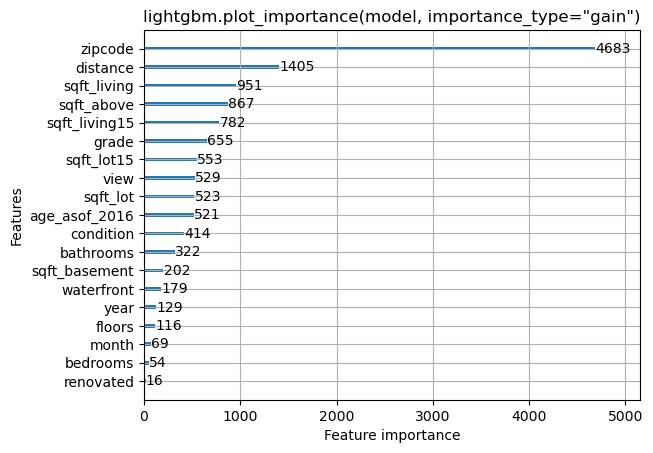

In [219]:
#feature importance
lightgbm.plot_importance(lgbm)
plt.title('lightgbm.plot_importance(model, importance_type="gain")')
plt.show()

## Model Stacking

In [224]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)


cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)



In [225]:
linreg_pipeline = make_pipeline(linear_preprocessor, linreg)
ridge_pipeline = make_pipeline(linear_preprocessor, ridge)
rf_pipeline = make_pipeline(tree_preprocessor, RandomForest)
xgb_pipeline = make_pipeline(tree_preprocessor, xgb)
lgbm_pipeline = make_pipeline(tree_preprocessor, lgbm)

#### Model 1
Models stacked: Linear Regression, Ridge, Random Forest, XGBoost, LightGBM
<br>
Meta-model:  XGBoost

In [ ]:
est_models_2 = [
    ("Linear Regression", linreg_pipeline),
    ("Ridge Regression", ridge_pipeline),
    ("Random Forest", rf_pipeline),
    ("LightGBM", lgbm_pipeline), 
    ("XGBoost", xgb_pipeline)
]

stacking_regressor2 = StackingRegressor(estimators=est_models_2, final_estimator=xgb)

stacking_regressor2.fit(X_train, y_train)
     
y_pred_stregr2_train=stacking_regressor2.predict(X_train)
y_pred_stregr2=stacking_regressor2.predict(X_test)

stregr2_trainscore = cross_val_score(stacking_regressor2 , X_train, y_train, cv = kf)
stregr2_testscore = stacking_regressor2.score(X_test, y_test)
stregr2_rmse_train = cross_val_score(stacking_regressor2, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
stregr2_rmse = np.sqrt(mse(y_test,y_pred_stregr2))

In [227]:
print('Train Accuracy Score:', round(stregr2_trainscore.mean(), 5))
print('Test Accuracy Score:', round(stregr2_testscore, 5))
print('Train RMSE:' , round(-stregr2_rmse_train.mean(), 5))
print('Test RMSE:' , round(stregr2_rmse, 5) )

Train Accuracy Score: 0.90084
Test Accuracy Score: 0.89809
Train RMSE: 0.16554
Test RMSE: 0.16982


#### Model 2
Models stacked: Ridge, Random Forest, XGBoost, LightGBM
<br>
Meta-model:  XGBoost

In [ ]:
est_models_3 = [
    ("Ridge Regression", ridge_pipeline),
    ("Random Forest", rf_pipeline),
    ("LightGBM", lgbm_pipeline), 
    ("XGBoost", xgb_pipeline)
]

stacking_regressor3 = StackingRegressor(estimators=est_models_3, final_estimator=xgb)

stacking_regressor3.fit(X_train, y_train)
                           
y_pred_stregr3_train=stacking_regressor3.predict(X_train)
y_pred_stregr3=stacking_regressor3.predict(X_test)

stregr3_trainscore = cross_val_score(stacking_regressor3 , X_train, y_train, cv = kf)
stregr3_testscore = stacking_regressor3.score(X_test, y_test)
stregr3_rmse_train = cross_val_score(stacking_regressor3, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
stregr3_rmse = np.sqrt(mse(y_test,y_pred_stregr3))

In [229]:
print('Train Accuracy Score:', round(stregr3_trainscore.mean(), 5))
print('Test Accuracy Score:', round(stregr3_testscore, 5))
print('Train RMSE:' , round(-stregr3_rmse_train.mean(), 5))
print('Test RMSE:' , round(stregr3_rmse, 5) )

Train Accuracy Score: 0.90169
Test Accuracy Score: 0.89835
Train RMSE: 0.16487
Test RMSE: 0.1696


#### Model 3
Models stacked: Linear Regression, Random Forest, XGBoost, LightGBM
<br>
Meta-model:  XGBoost

In [ ]:
est_models_4 = [
    ("Linear Regression", linreg_pipeline),
    ("Random Forest", rf_pipeline),
    ("LightGBM", lgbm_pipeline), 
    ("XGBoost", xgb_pipeline)
]

stacking_regressor4 = StackingRegressor(estimators=est_models_4, final_estimator=xgb)

stacking_regressor4.fit(X_train, y_train)
                           
y_pred_stregr4_train=stacking_regressor4.predict(X_train)
y_pred_stregr4=stacking_regressor4.predict(X_test)

stregr4_trainscore = cross_val_score(stacking_regressor4 , X_train, y_train, cv = kf)
stregr4_testscore = stacking_regressor4.score(X_test, y_test)
stregr4_rmse_train = cross_val_score(stacking_regressor4, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
stregr4_rmse = np.sqrt(mse(y_test,y_pred_stregr3))

In [231]:
print('Train Accuracy Score:', round(stregr4_trainscore.mean(), 5))
print('Test Accuracy Score:', round(stregr4_testscore, 5))
print('Train RMSE:' , round(-stregr4_rmse_train.mean(), 5))
print('Test RMSE:' , round(stregr4_rmse, 5) )

Train Accuracy Score: 0.90166
Test Accuracy Score: 0.89858
Train RMSE: 0.16497
Test RMSE: 0.1696


#### Model 4
Models stacked: Ridge, Random Forest, XGBoost
<br>
Meta-model:  LightGBM

In [ ]:
est_models_5 = [
    ("Ridge Regression", ridge_pipeline),
    ("Random Forest", rf_pipeline),
    ("XGBoost", xgb_pipeline)
]

stacking_regressor5 = StackingRegressor(estimators=est_models_5, final_estimator= lgbm, cv=5, n_jobs=-1)

stacking_regressor5.fit(X_train, y_train)
                           
y_pred_stregr5_train=stacking_regressor5.predict(X_train)
y_pred_stregr5=stacking_regressor5.predict(X_test)

stregr5_trainscore = cross_val_score(stacking_regressor5 , X_train, y_train, cv = kf)
stregr5_testscore = stacking_regressor5.score(X_test, y_test)
stregr5_rmse_train = cross_val_score(stacking_regressor5, X_train, y_train, cv = kf, scoring='neg_root_mean_squared_error')
stregr5_rmse = np.sqrt(mse(y_test,y_pred_stregr5))

In [236]:
print('Train Accuracy Score:', round(stregr5_trainscore.mean(), 5))
print('Test Accuracy Score:', round(stregr5_testscore, 5))
print('Train RMSE:' , round(-stregr5_rmse_train.mean(), 5))
print('Test RMSE:' , round(stregr5_rmse, 5) )

Train Accuracy Score: 0.88177
Test Accuracy Score: 0.87931
Train RMSE: 0.18056
Test RMSE: 0.1848


### Saving Trained Models

In [237]:
import pickle
LRfilename = "linreg.pickle"
Ridgefilename = "ridge.pickle"
RFfilename = "RandomForest.pickle"
xgbfilename = "xgb.pickle"
lgbmfilename = "lgbm.pickle"
est_models_2_filename = "stacking_regressor2.pickle"
est_models_3_filename = "stacking_regressor3.pickle"
est_models_4_filename = "stacking_regressor4.pickle"
est_models_5_filename = "stacking_regressor5.pickle"

In [238]:
pickle.dump(linreg, open(LRfilename, "wb"))

pickle.dump(ridge, open(Ridgefilename, "wb"))

pickle.dump(RandomForest, open(RFfilename, "wb"))

pickle.dump(xgb, open(xgbfilename, "wb"))

pickle.dump(lgbm, open(lgbmfilename, "wb"))

# stacked models
pickle.dump(stacking_regressor2, open(est_models_2_filename, "wb"))
pickle.dump(stacking_regressor3, open(est_models_3_filename, "wb"))
pickle.dump(stacking_regressor4, open(est_models_4_filename, "wb"))
pickle.dump(stacking_regressor5, open(est_models_5_filename, "wb"))

In [8]:
#load models
linreg = pickle.load(open(LRfilename, "rb"))
ridge = pickle.load(open(Ridgefilename, "rb"))
RandomForest = pickle.load(open(RFfilename, "rb"))
xgb = pickle.load(open(xgbfilename, "rb"))
lgbm = pickle.load(open(lgbmfilename, "rb"))
stacking_regressor2 = pickle.load(open(est_models_2_filename, "rb"))
stacking_regressor3 = pickle.load(open(est_models_3_filename, "rb"))
stacking_regressor4 = pickle.load(open(est_models_4_filename, "rb"))
stacking_regressor5 = pickle.load(open(est_models_5_filename, "rb"))